In [1]:
# imports
from pathlib import Path
import geopandas as gpd
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt
import rioxarray as rxr
import seaborn as sns
from osgeo import gdal
import subprocess
import os

In [2]:
data_path = Path("data")

reference_raster = rasterio.open(data_path / "landcover_2010_nyc_3ft_mn.tif")

In [3]:
# read geoparquet into a gdf
out_data_name = "buildings"
file_ext = "parquet"
bldg_gdf = gpd.read_parquet(data_path / f"{out_data_name}.{file_ext}")

# fill null values in either elevation col with 0s
bldg_gdf.fillna({'groundelev':0,'heightroof':0},inplace=True)

print(f"num of rows in bldg dataset: {len(bldg_gdf)}")

num of rows in bldg dataset: 1083122


In [4]:
# calculate integer roof height relative to sealevel, not grade
bldg_gdf["roof_hgt_from_sealvl"] = (bldg_gdf.heightroof + bldg_gdf.groundelev).astype(
    int
)

In [5]:
bldg_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1083122 entries, 0 to 1083121
Data columns (total 18 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   name                  2254 non-null     object        
 1   bin                   1083122 non-null  float64       
 2   cnstrct_yr            1072853 non-null  float64       
 3   date_lstmo            1083122 non-null  datetime64[ms]
 4   time_lstmo            1083122 non-null  object        
 5   lststatype            1082795 non-null  object        
 6   doitt_id              1083122 non-null  float64       
 7   heightroof            1083122 non-null  float64       
 8   feat_code             1083122 non-null  float64       
 9   groundelev            1083122 non-null  float64       
 10  shape_area            1083122 non-null  float64       
 11  shape_len             1083122 non-null  float64       
 12  base_bbl              1083122 non-

In [6]:
# subset geoparquet to only include MN for testing
mn_bldg_gdf = bldg_gdf.query("base_bbl.str.startswith('1')")

print(f"num of rows in mn bldg dataset: {len(mn_bldg_gdf)}")

num of rows in mn bldg dataset: 45336


In [7]:
count = mn_bldg_gdf.groupby(by=['roof_hgt_from_sealvl']).size()
display(count)

roof_hgt_from_sealvl
-1        1
 0       50
 6        3
 7        7
 8        5
         ..
 1413     1
 1445     1
 1461     1
 1486     1
 1630     1
Length: 686, dtype: int64

<Axes: xlabel='roof_hgt_from_sealvl'>

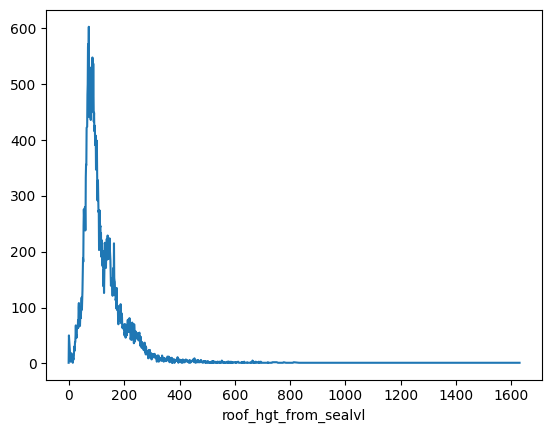

In [8]:
count.plot()

In [9]:
## rasterize bldg footprints

geom = [shapes for shapes in mn_bldg_gdf.geometry]

# generate tuples of geometry, value pairs, where value is the attribute value you want to burn
geom_value = (
    (geom, value)
    for geom, value in zip(mn_bldg_gdf.geometry, mn_bldg_gdf["roof_hgt_from_sealvl"])
)

# Rasterize vector using the shape and transform of the raster
rasterized = rasterio.features.rasterize(
    shapes=geom_value,
    out_shape=reference_raster.shape,
    transform=reference_raster.transform,
    all_touched=True,
    fill=0,  # background value
    merge_alg=rasterio.enums.MergeAlg.replace,
    # dtype=np.int16,
)

In [10]:
out_raster = "mn_bldg_raster.tif"

with rasterio.open(
    fp=data_path / f"{out_raster}",
    mode="w",
    driver="GTiff",
    width=reference_raster.width,   # width in rows
    height=reference_raster.height, # height in rows
    count=1,                        # number of bands
    crs=reference_raster.crs,
    transform=reference_raster.transform,
    dtype=rasterio.float32,           # dtype must be float, else lose elev resolution
) as dst:
    dst.write(
        arr=rasterized,             # array to write to raster
        indexes=1,                  # bands to write to
        )

In [11]:
mn_bldg_raster = rasterio.open(data_path / "mn_bldg_raster.tif")

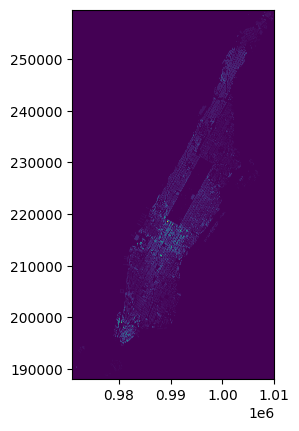

<Axes: >

In [12]:
rasterio.plot.show(mn_bldg_raster)

In [13]:
# Prettier plotting with seaborn
sns.set_theme(font_scale=1.5, style="whitegrid")

In [14]:
# Open data 
mn_bldg_xarray = rxr.open_rasterio(data_path / "mn_bldg_raster.tif", masked=True)

# View object dimensions
mn_bldg_xarray.shape

(1, 23820, 13017)

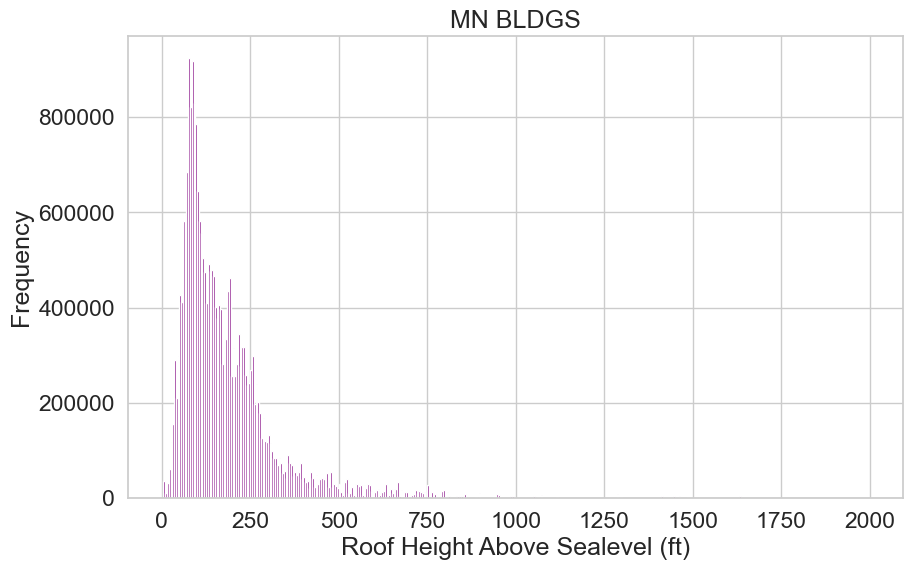

In [15]:
# Plot a histogram
bins = [x for x in range(5,2000,5)]
f, ax = plt.subplots(figsize=(10, 6))
mn_bldg_xarray.plot.hist(
    ax=ax,
    color="purple",
    bins=bins,
)
ax.set(title="MN BLDGS", xlabel="Roof Height Above Sealevel (ft)", ylabel="Frequency")

plt.show()

In [24]:
result = subprocess.call(
    'gdalinfo --version', 
    shell=True
    )

#print(result.stderr)

FileNotFoundError: [Errno 2] No such file or directory: 'gdalinfo --version'

In [ ]:
# run viewshed
target_raster = "mn_bldg_raster.tif"
band = gdal.OpenEx(data_path / target_raster)
viewshed = gdal.ViewshedGenerate(
    srcBand = band.GetRasterBand(1),
    driverName = 'GTiff',
    targetRasterName = target_raster,
    creationOptions = None,
    observerX = 985049,
    observerY = 206221,
    observerHeight = 1.0,
    targetHeight = 1.0,
    visibleVal = 255.0,
    invisibleVal = 0.0,
    outOfRangeVal = -100,
    noDataVal = -100,
    dfCurvCoeff = 1.0,
    mode = 1,
    maxDistance = 79200.0,
)

In [75]:
def generate_viewshed(
    in_file: Path | str,
    out_file: Path | str,
    observer_x: int | float,
    observer_y: int | float,
    observer_z: int | float,
    target_z: int | float,
    max_dist: int | float,
    driver: str = "GTiff",
    
) -> int:
    """_summary_

    Args:
        in_file (Path | str): _description_
        out_file (Path | str): _description_
        observer_x (int | float): _description_
        observer_y (int | float): _description_
        observer_z (int | float): _description_
        target_z (int | float): _description_
        max_dist (int | float): _description_
        driver (str, optional): _description_. Defaults to "GTiff".

    Returns:
        int: return code, where 0 == success and 1 == failure
    """
    result = subprocess.call(
        [
            f"gdal_viewshed \
            -b 1 \
            -ox {observer_x} \
            -oy {observer_y} \
            -oz {observer_z} \
            -tz {target_z} \
            -md {max_dist} \
            -f {driver} \
            {in_file} \
            {out_file}",
        ],
        text=True,
        shell=True,
    )
    return result

In [78]:
target_raster = "mn_bldg_raster.tif"
in_file = data_path.absolute() / target_raster
out_file = data_path.absolute() / "vshed_5.tif"
observer_x = 991518
observer_y = 220276
observer_z = 200
target_z = 200
max_dist = 79200.0  # or, 15 miles

result = generate_viewshed(
    in_file=in_file,
    out_file=out_file,
    observer_x=observer_x,
    observer_y=observer_y,
    observer_z=observer_z,
    target_z=target_z,
    max_dist=max_dist,
)

0...10...20...30...40...50...60...70...80...90...100 - done.


In [61]:
def check_gdal_version(
    command: str,
    flag: str,
) -> int:
    result = subprocess.call(
        [
            f"{command}", f"{flag}"
        ],
        text=True,
        #shell=True,
    )
    return result

In [62]:
check_gdal_version(
    command="gdalinfo",
    flag="--version"
    )

GDAL 3.9.0, released 2024/05/07


0

In [74]:
print(out_file)

/Users/jackrosacker/files/projects/building-viewshed/data/vshed_3.tif
